In [ ]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, LSTM
import matplotlib.pyplot as plt

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.11.0
Running on TPU  ['10.58.113.2:8470']


In [ ]:
from google.colab import drive

drive.mount('/gdrive', force_remount = True)

Xd = pd.read_pickle("/gdrive/MyDrive/RML2016.10a_dict.pkl")

Mounted at /gdrive


In [ ]:
# Load the dataset ...
#  You will need to seperately download or generate this file

snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

print(X_train.transpose((0,2,1)).shape)

X_train = X_train.transpose((0,2,1))
X_test = X_test.transpose((0,2,1))

(110000, 2, 128) [2, 128]
(110000, 128, 2)


In [ ]:
inputs = Input(shape=(None, 128, 2))

with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = keras.Sequential()
  model.add(layers.Bidirectional(LSTM(32, return_sequences=True)))
  model.add(layers.Bidirectional(LSTM(32, return_sequences=True)))
  model.add(layers.Bidirectional(LSTM(32, return_sequences=False)))
  model.add(layers.Dense(32, activation="relu"))
  model.add(layers.Dense(32, activation="relu"))
  model.add(layers.Dense(32, activation="relu"))
  model.add(layers.Dense(len(classes), activation="softmax"))

  model.build((None,128,2))
  model.compile(optimizer='Adam', loss='categorical_crossentropy')
model.summary()



ValueError: ignored

In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, TimeDistributed
from keras.models import Model

# Define input shape
inputs = Input(shape=(None, 128, 2))

# Add convolutional layers
x = TimeDistributed(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))(inputs)
x = TimeDistributed(MaxPooling1D(pool_size=2))(x)
x = TimeDistributed(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))(x)
x = TimeDistributed(MaxPooling1D(pool_size=2))(x)

# Add recurrent layers
x = TimeDistributed(LSTM(units=64, return_sequences=True))(x)
x = Dropout(rate=0.5)(x)
x = LSTM(units=64)(x)

# Add fully connected layers
x = Dense(units=128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)
outputs = Dense(units=len(classes), activation='softmax')(x)

# Define model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='Adam', loss='categorical_crossentropy')
model.summary()


ValueError: ignored

In [ ]:
filepath = 'test.wts.h5'
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    #show_accuracy=True,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100
108/108 - 50s - loss: 2.3706 - val_loss: 2.3805 - 50s/epoch - 458ms/step
Epoch 2/100
108/108 - 19s - loss: 2.2804 - val_loss: 2.2208 - 19s/epoch - 177ms/step
Epoch 3/100
108/108 - 19s - loss: 2.2069 - val_loss: 2.1985 - 19s/epoch - 178ms/step
Epoch 4/100
108/108 - 19s - loss: 2.1927 - val_loss: 2.2024 - 19s/epoch - 172ms/step
Epoch 5/100
108/108 - 19s - loss: 2.1832 - val_loss: 2.1812 - 19s/epoch - 174ms/step
Epoch 6/100
108/108 - 19s - loss: 2.1817 - val_loss: 2.1865 - 19s/epoch - 172ms/step
Epoch 7/100
108/108 - 19s - loss: 2.1806 - val_loss: 2.1794 - 19s/epoch - 175ms/step
Epoch 8/100
108/108 - 19s - loss: 2.1797 - val_loss: 2.1837 - 19s/epoch - 172ms/step
Epoch 9/100
108/108 - 19s - loss: 2.1723 - val_loss: 2.2062 - 19s/epoch - 174ms/step
Epoch 10/100
108/108 - 19s - loss: 2.1684 - val_loss: 2.1768 - 19s/epoch - 173ms/step
Epoch 11/100
108/108 - 19s - loss: 2.1579 - val_loss: 2.1638 - 19s/epoch - 175ms/step
Epoch 12/100
108/108 - 19s - loss: 2.2113 - val_loss: 2.3871 - 

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)

1.6249586343765259


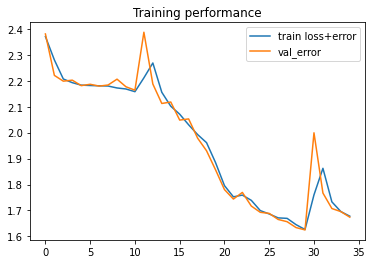

In [ ]:
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

(110000, 128, 2)
108/108 [==============================] - 10s 52ms/step
For Bi-LSTM without Attention
Number of signals: 110000
Average time per perdiction: 0.1091361899727293
Total Time taken: 12.004980897000223


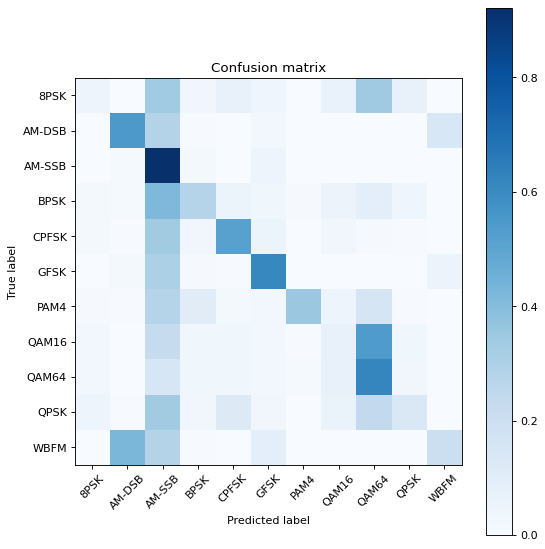

In [ ]:
print(X_test.shape)
start_time = time.perf_counter()
test_Y_hat = model.predict(X_test, batch_size=batch_size)
end_time = time.perf_counter()
avg_time = (end_time - start_time)/X_test.shape[0]
print("For Bi-LSTM without Attention") 
print("Number of signals: " + str(X_test.shape[0]) )
print("Average time per perdiction: " + str(avg_time * 1e3))
print("Total Time taken: " + str(end_time-start_time))

conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plt.figure(figsize=(7, 7), dpi=80)

plot_confusion_matrix(confnorm, labels=classes)

6/6 [==============================] - 2s 270ms/step
Overall Accuracy:  0.09167429094236047
6/6 [==============================] - 2s 312ms/step
Overall Accuracy:  0.09227974568574024
6/6 [==============================] - 2s 319ms/step
Overall Accuracy:  0.09442836468885674
6/6 [==============================] - 2s 316ms/step
Overall Accuracy:  0.09599422591122339
6/6 [==============================] - 2s 274ms/step
Overall Accuracy:  0.13691886964448496
6/6 [==============================] - 2s 227ms/step
Overall Accuracy:  0.2129020792607073
6/6 [==============================] - 2s 270ms/step
Overall Accuracy:  0.2884438728642293
6/6 [==============================] - 2s 268ms/step
Overall Accuracy:  0.3084677419354839
6/6 [==============================] - 2s 248ms/step
Overall Accuracy:  0.36044362292051757
6/6 [==============================] - 1s 31ms/step
Overall Accuracy:  0.4399492017416546
6/6 [==============================] - 2s 267ms/step
Overall Accuracy:  0.51879562043

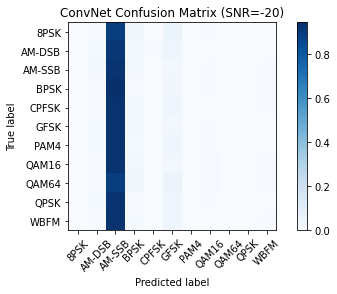

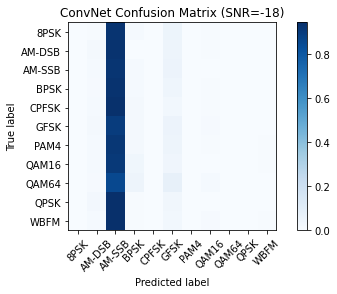

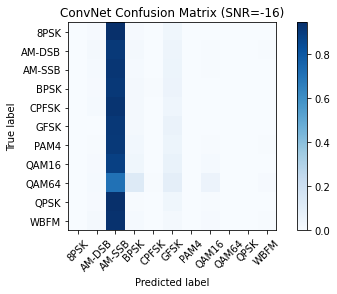

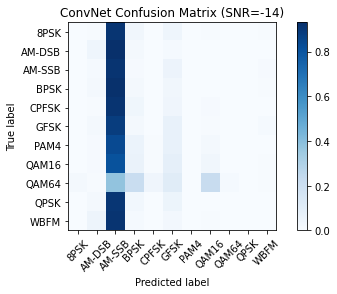

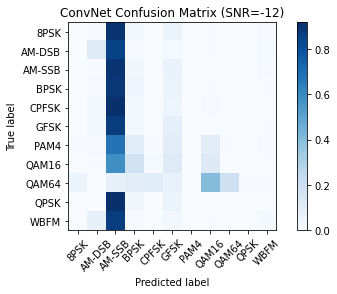

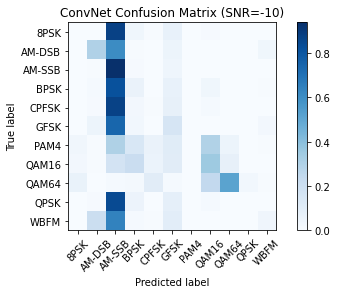

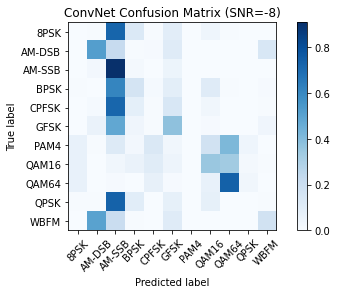

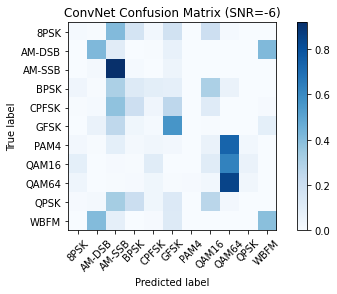

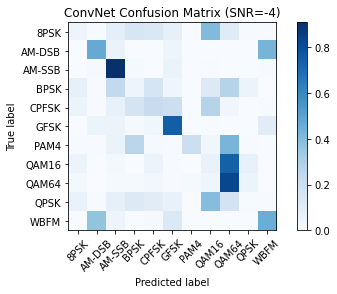

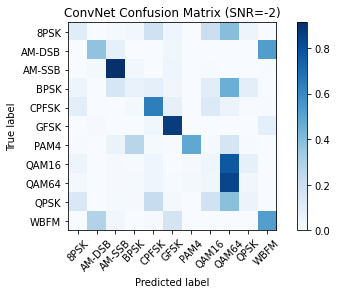

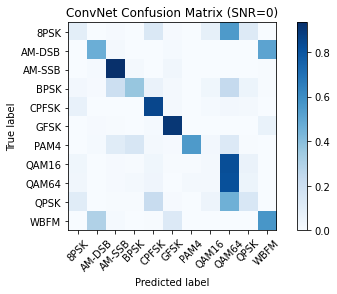

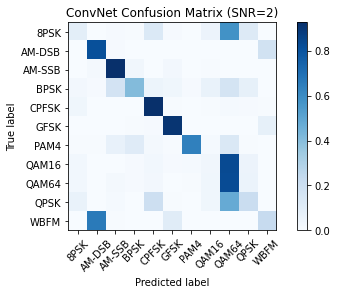

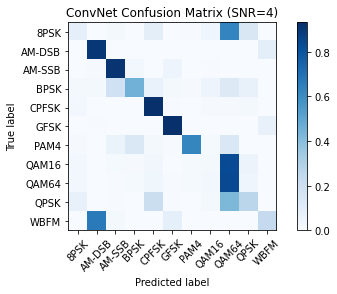

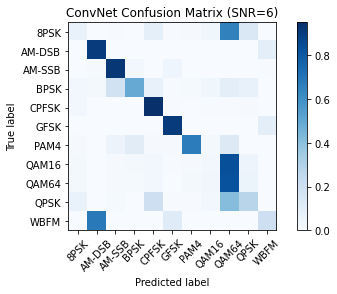

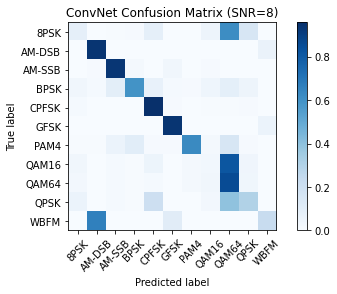

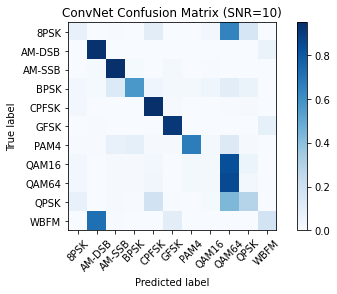

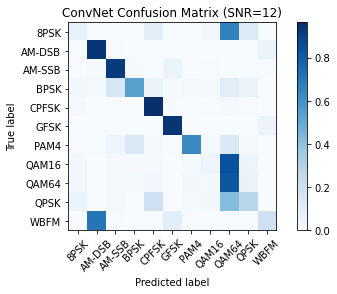

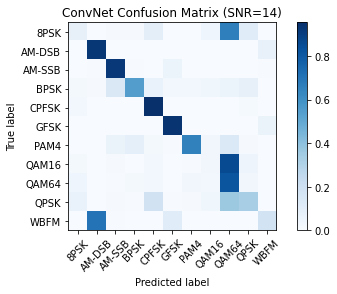

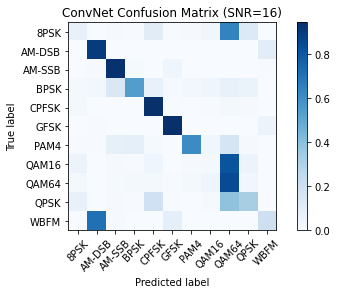

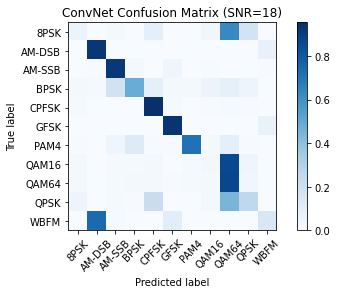

In [ ]:
acc = {}
test_SNRs = np.array( list(map(lambda x: lbl[x][1], test_idx) ) )
for snr in snrs:

    # extract classes @ SNR
    #print(np.where(np.array(test_SNRs))==snr)
    #test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    #test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    
    test_X_i = X_test[np.nonzero(test_SNRs == snr)]
    test_Y_i = Y_test[np.nonzero(test_SNRs == snr)]
    #test_X_i = np.expand_dims( test_X_i, axis = 1 )
    if ( test_X_i.shape[0] == 0 ):
      continue
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i, batch_size = 1024 )
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)